In [19]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
from datetime import datetime

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import optuna
import shap

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load and Prepare Data

In [20]:
# Load training data
df = pd.read_csv("../data/processed/training_data_real.csv")

print("="*80)
print("TRAINING DATA LOADED")
print("="*80)
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nTarget variable: risk_score")
print(f"  Min: {df['risk_score'].min():.2f}")
print(f"  Max: {df['risk_score'].max():.2f}")
print(f"  Mean: {df['risk_score'].mean():.2f}")
print(f"\nRisk categories:")
print(df['risk_category'].value_counts())

df.head()

TRAINING DATA LOADED
Shape: (2700, 26)

Columns: ['region', 'district', 'latitude', 'longitude', 'ndvi_mean', 'ndvi_max', 'ndvi_min', 'ndvi_std', 'lst_mean_c', 'lst_max_c', 'lst_min_c', 'precipitation_annual_mm', 'crop', 'crop_category', 'crop_temp_min', 'crop_temp_max', 'crop_water_need', 'crop_ndvi_min', 'crop_drought_sens', 'crop_frost_sens', 'region_suitable', 'temp_match', 'water_match', 'ndvi_score', 'risk_score', 'risk_category']

Target variable: risk_score
  Min: 29.20
  Max: 92.90
  Mean: 67.70

Risk categories:
risk_category
green     1385
yellow    1235
red         80
Name: count, dtype: int64


,region,district,latitude,longitude,ndvi_mean,ndvi_max,ndvi_min,ndvi_std,lst_mean_c,lst_max_c,...,crop_water_need,crop_ndvi_min,crop_drought_sens,crop_frost_sens,region_suitable,temp_match,water_match,ndvi_score,risk_score,risk_category
0,Tashkent City,Almazar,41.3167,69.2167,0.214,0.3311,0.0707,0.0698,24.7,43.6,...,700,0.40,0.5,0.8,0,0.728,0.521714,0.6,50.6,yellow
1,Tashkent City,Almazar,41.3167,69.2167,0.214,0.3311,0.0707,0.0698,24.7,43.6,...,450,0.35,0.3,0.2,1,0.828,0.716311,0.6,75.0,green
2,Tashkent City,Almazar,41.3167,69.2167,0.214,0.3311,0.0707,0.0698,24.7,43.6,...,1200,0.45,0.9,0.8,0,0.688,0.250767,0.6,38.6,red
3,Tashkent City,Almazar,41.3167,69.2167,0.214,0.3311,0.0707,0.0698,24.7,43.6,...,500,0.40,0.5,0.8,1,0.688,0.630400,0.6,70.6,green
4,Tashkent City,Almazar,41.3167,69.2167,0.214,0.3311,0.0707,0.0698,24.7,43.6,...,600,0.35,0.7,0.8,0,0.628,0.509267,0.6,46.5,yellow


In [21]:
# Define feature columns and target
# Exclude identifiers and target variables
exclude_cols = ['risk_score', 'risk_category']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Feature columns ({len(feature_cols)}):")
for col in feature_cols:
    print(f"  - {col}")

# Identify categorical columns
categorical_cols = ['region', 'district', 'crop', 'crop_category']
numerical_cols = [col for col in feature_cols if col not in categorical_cols]

print(f"\nCategorical features: {len(categorical_cols)}")
print(f"Numerical features: {len(numerical_cols)}")

Feature columns (24):
  - region
  - district
  - latitude
  - longitude
  - ndvi_mean
  - ndvi_max
  - ndvi_min
  - ndvi_std
  - lst_mean_c
  - lst_max_c
  - lst_min_c
  - precipitation_annual_mm
  - crop
  - crop_category
  - crop_temp_min
  - crop_temp_max
  - crop_water_need
  - crop_ndvi_min
  - crop_drought_sens
  - crop_frost_sens
  - region_suitable
  - temp_match
  - water_match
  - ndvi_score

Categorical features: 4
Numerical features: 20


In [22]:
# Encode categorical variables
label_encoders = {}
df_encoded = df.copy()

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"✓ Encoded {col}: {len(le.classes_)} unique values")

print(f"\n✓ All categorical variables encoded")
print(f"✓ Label encoders saved for later use")

✓ Encoded region: 14 unique values
✓ Encoded district: 180 unique values
✓ Encoded crop: 15 unique values
✓ Encoded crop_category: 6 unique values

✓ All categorical variables encoded
✓ Label encoders saved for later use


In [23]:
# Split data into train/validation/test sets
X = df_encoded[feature_cols]
y = df_encoded['risk_score']

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 75% train, 25% val (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print("="*80)
print("DATA SPLIT")
print("="*80)
print(f"Training set:   {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n✓ Data split complete")

DATA SPLIT
Training set:   1,620 samples (60.0%)
Validation set: 540 samples (20.0%)
Test set:       540 samples (20.0%)

✓ Data split complete


## 2. Hyperparameter Optimization with Optuna

In [24]:
def objective(trial):
    """
    Optuna objective function for LightGBM hyperparameter tuning.
    """
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }
    
    # Create datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Train model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    # Evaluate on validation set
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    mae = mean_absolute_error(y_val, y_pred)
    
    return mae

print("✓ Optimization objective function defined")

✓ Optimization objective function defined


In [25]:
# Run Optuna optimization
print("="*80)
print("STARTING HYPERPARAMETER OPTIMIZATION")
print("="*80)
print("This may take 5-10 minutes...\n")

study = optuna.create_study(direction='minimize', study_name='lightgbm_optimization')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*80)
print("OPTIMIZATION COMPLETE")
print("="*80)
print(f"Best MAE: {study.best_value:.4f}")
print(f"\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-05 02:00:46,240] A new study created in memory with name: lightgbm_optimization


STARTING HYPERPARAMETER OPTIMIZATION
This may take 5-10 minutes...



Best trial: 0. Best value: 1.70103:   2%|▏         | 1/50 [00:00<00:22,  2.20it/s]

[I 2025-12-05 02:00:46,695] Trial 0 finished with value: 1.7010260298916053 and parameters: {'num_leaves': 139, 'learning_rate': 0.06043336893684229, 'feature_fraction': 0.5963663001331465, 'bagging_fraction': 0.7532531034533445, 'bagging_freq': 3, 'min_child_samples': 97, 'lambda_l1': 0.5314487420885663, 'lambda_l2': 5.048818858900054e-07}. Best is trial 0 with value: 1.7010260298916053.


Best trial: 1. Best value: 1.67854:   4%|▍         | 2/50 [00:01<00:43,  1.11it/s]

[I 2025-12-05 02:00:47,907] Trial 1 finished with value: 1.678536493134503 and parameters: {'num_leaves': 24, 'learning_rate': 0.015388414292551136, 'feature_fraction': 0.8844560522120537, 'bagging_fraction': 0.802946915368136, 'bagging_freq': 2, 'min_child_samples': 43, 'lambda_l1': 1.446995676616191, 'lambda_l2': 0.0001898220809536683}. Best is trial 1 with value: 1.678536493134503.


Best trial: 1. Best value: 1.67854:   6%|▌         | 3/50 [00:02<00:32,  1.45it/s]

[I 2025-12-05 02:00:48,342] Trial 2 finished with value: 1.6849549351100062 and parameters: {'num_leaves': 127, 'learning_rate': 0.038691871218159805, 'feature_fraction': 0.7959860312199649, 'bagging_fraction': 0.7561832690025669, 'bagging_freq': 4, 'min_child_samples': 47, 'lambda_l1': 0.020637674109708355, 'lambda_l2': 2.96112011002509}. Best is trial 1 with value: 1.678536493134503.


Best trial: 1. Best value: 1.67854:   8%|▊         | 4/50 [00:04<00:54,  1.19s/it]

[I 2025-12-05 02:00:50,304] Trial 3 finished with value: 1.775048413613664 and parameters: {'num_leaves': 139, 'learning_rate': 0.01803901534304045, 'feature_fraction': 0.6319981024769155, 'bagging_fraction': 0.6545896015154169, 'bagging_freq': 7, 'min_child_samples': 17, 'lambda_l1': 0.0133117636854738, 'lambda_l2': 0.004709467797711824}. Best is trial 1 with value: 1.678536493134503.


Best trial: 1. Best value: 1.67854:  10%|█         | 5/50 [00:04<00:43,  1.04it/s]

[I 2025-12-05 02:00:50,862] Trial 4 finished with value: 1.9593167060211272 and parameters: {'num_leaves': 137, 'learning_rate': 0.17343937419705185, 'feature_fraction': 0.6938314071073935, 'bagging_fraction': 0.5258481685672879, 'bagging_freq': 3, 'min_child_samples': 5, 'lambda_l1': 6.103852592196556, 'lambda_l2': 2.177597180641334e-05}. Best is trial 1 with value: 1.678536493134503.


Best trial: 1. Best value: 1.67854:  12%|█▏        | 6/50 [00:04<00:31,  1.40it/s]

[I 2025-12-05 02:00:51,092] Trial 5 finished with value: 1.707932901616775 and parameters: {'num_leaves': 36, 'learning_rate': 0.11423842442331264, 'feature_fraction': 0.8194820513265147, 'bagging_fraction': 0.8652612270179303, 'bagging_freq': 3, 'min_child_samples': 73, 'lambda_l1': 4.686030905175777e-07, 'lambda_l2': 4.410030974457598e-08}. Best is trial 1 with value: 1.678536493134503.


Best trial: 1. Best value: 1.67854:  16%|█▌        | 8/50 [00:06<00:25,  1.65it/s]

[I 2025-12-05 02:00:52,139] Trial 6 finished with value: 1.8470412684979254 and parameters: {'num_leaves': 62, 'learning_rate': 0.05327132477268768, 'feature_fraction': 0.5728297636309747, 'bagging_fraction': 0.7102532496392848, 'bagging_freq': 7, 'min_child_samples': 12, 'lambda_l1': 0.007611595034749917, 'lambda_l2': 2.545454800513473e-07}. Best is trial 1 with value: 1.678536493134503.
[I 2025-12-05 02:00:52,280] Trial 7 finished with value: 1.7983534127401504 and parameters: {'num_leaves': 90, 'learning_rate': 0.2525367597122778, 'feature_fraction': 0.9423392879173341, 'bagging_fraction': 0.8044837663091693, 'bagging_freq': 3, 'min_child_samples': 68, 'lambda_l1': 5.289270007399625e-07, 'lambda_l2': 0.00033301694808456365}. Best is trial 1 with value: 1.678536493134503.


Best trial: 1. Best value: 1.67854:  18%|█▊        | 9/50 [00:06<00:24,  1.68it/s]

[I 2025-12-05 02:00:52,847] Trial 8 finished with value: 1.7284983790010893 and parameters: {'num_leaves': 43, 'learning_rate': 0.06438788057547083, 'feature_fraction': 0.8193391287204368, 'bagging_fraction': 0.5714715956865095, 'bagging_freq': 2, 'min_child_samples': 8, 'lambda_l1': 0.6984687690083539, 'lambda_l2': 1.4400649747675833}. Best is trial 1 with value: 1.678536493134503.


Best trial: 1. Best value: 1.67854:  20%|██        | 10/50 [00:08<00:41,  1.05s/it]

[I 2025-12-05 02:00:54,915] Trial 9 finished with value: 1.7091121669283695 and parameters: {'num_leaves': 141, 'learning_rate': 0.011281355616037452, 'feature_fraction': 0.5879452654067867, 'bagging_fraction': 0.825246594216817, 'bagging_freq': 5, 'min_child_samples': 43, 'lambda_l1': 2.6191697891097557e-07, 'lambda_l2': 1.0990061962966278e-06}. Best is trial 1 with value: 1.678536493134503.


Best trial: 10. Best value: 1.66089:  22%|██▏       | 11/50 [00:09<00:37,  1.03it/s]

[I 2025-12-05 02:00:55,694] Trial 10 finished with value: 1.6608882004997623 and parameters: {'num_leaves': 21, 'learning_rate': 0.022855269214916055, 'feature_fraction': 0.9897730869987553, 'bagging_fraction': 0.9814787997318677, 'bagging_freq': 1, 'min_child_samples': 33, 'lambda_l1': 4.298972591565446e-05, 'lambda_l2': 0.0338921273476002}. Best is trial 10 with value: 1.6608882004997623.


Best trial: 10. Best value: 1.66089:  24%|██▍       | 12/50 [00:10<00:34,  1.10it/s]

[I 2025-12-05 02:00:56,479] Trial 11 finished with value: 1.6813425254353442 and parameters: {'num_leaves': 23, 'learning_rate': 0.023973283471156247, 'feature_fraction': 0.9957129502225085, 'bagging_fraction': 0.983886360685837, 'bagging_freq': 1, 'min_child_samples': 34, 'lambda_l1': 5.2652327965229136e-05, 'lambda_l2': 0.01973944239266074}. Best is trial 10 with value: 1.6608882004997623.


Best trial: 10. Best value: 1.66089:  26%|██▌       | 13/50 [00:12<00:46,  1.25s/it]

[I 2025-12-05 02:00:58,524] Trial 12 finished with value: 1.6911871523638673 and parameters: {'num_leaves': 66, 'learning_rate': 0.010414211573756287, 'feature_fraction': 0.9077511744245592, 'bagging_fraction': 0.9888411638442562, 'bagging_freq': 1, 'min_child_samples': 35, 'lambda_l1': 5.329239516712142e-05, 'lambda_l2': 0.03136522928876147}. Best is trial 10 with value: 1.6608882004997623.


Best trial: 10. Best value: 1.66089:  28%|██▊       | 14/50 [00:13<00:40,  1.13s/it]

[I 2025-12-05 02:00:59,365] Trial 13 finished with value: 1.6964926559484752 and parameters: {'num_leaves': 23, 'learning_rate': 0.022097875685391316, 'feature_fraction': 0.8945918427535097, 'bagging_fraction': 0.906057886561292, 'bagging_freq': 1, 'min_child_samples': 62, 'lambda_l1': 0.00041258489213233764, 'lambda_l2': 0.00018189445299762744}. Best is trial 10 with value: 1.6608882004997623.


Best trial: 10. Best value: 1.66089:  30%|███       | 15/50 [00:13<00:36,  1.05s/it]

[I 2025-12-05 02:01:00,220] Trial 14 finished with value: 1.6908285771813416 and parameters: {'num_leaves': 96, 'learning_rate': 0.03224964461137539, 'feature_fraction': 0.9938958963993212, 'bagging_fraction': 0.9167815558253475, 'bagging_freq': 2, 'min_child_samples': 28, 'lambda_l1': 7.014340169590816e-06, 'lambda_l2': 0.0012457499123341295}. Best is trial 10 with value: 1.6608882004997623.


Best trial: 10. Best value: 1.66089:  32%|███▏      | 16/50 [00:14<00:34,  1.02s/it]

[I 2025-12-05 02:01:01,185] Trial 15 finished with value: 1.6922488633883888 and parameters: {'num_leaves': 52, 'learning_rate': 0.016040614230362786, 'feature_fraction': 0.8749781074527999, 'bagging_fraction': 0.6184940305576977, 'bagging_freq': 2, 'min_child_samples': 56, 'lambda_l1': 3.129940478092149e-08, 'lambda_l2': 2.2378380636420622e-05}. Best is trial 10 with value: 1.6608882004997623.


Best trial: 10. Best value: 1.66089:  34%|███▍      | 17/50 [00:15<00:29,  1.11it/s]

[I 2025-12-05 02:01:01,796] Trial 16 finished with value: 1.6891868899375768 and parameters: {'num_leaves': 112, 'learning_rate': 0.03310280658504544, 'feature_fraction': 0.7195296742839332, 'bagging_fraction': 0.9299639454337353, 'bagging_freq': 5, 'min_child_samples': 81, 'lambda_l1': 0.0009879429912732962, 'lambda_l2': 0.2963084232980174}. Best is trial 10 with value: 1.6608882004997623.


Best trial: 10. Best value: 1.66089:  36%|███▌      | 18/50 [00:17<00:43,  1.35s/it]

[I 2025-12-05 02:01:04,205] Trial 17 finished with value: 1.8198085738625909 and parameters: {'num_leaves': 73, 'learning_rate': 0.014850407780201988, 'feature_fraction': 0.5115173814231451, 'bagging_fraction': 0.8215501118543272, 'bagging_freq': 1, 'min_child_samples': 23, 'lambda_l1': 2.6390173889886424e-05, 'lambda_l2': 0.25237981550892}. Best is trial 10 with value: 1.6608882004997623.


Best trial: 10. Best value: 1.66089:  38%|███▊      | 19/50 [00:18<00:34,  1.12s/it]

[I 2025-12-05 02:01:04,768] Trial 18 finished with value: 1.709271951580341 and parameters: {'num_leaves': 35, 'learning_rate': 0.024690895099234205, 'feature_fraction': 0.9441576324713048, 'bagging_fraction': 0.6947708759126329, 'bagging_freq': 2, 'min_child_samples': 52, 'lambda_l1': 0.21600923216391388, 'lambda_l2': 1.67398787106339e-05}. Best is trial 10 with value: 1.6608882004997623.


Best trial: 10. Best value: 1.66089:  40%|████      | 20/50 [00:20<00:38,  1.28s/it]

[I 2025-12-05 02:01:06,430] Trial 19 finished with value: 1.669534974187512 and parameters: {'num_leaves': 50, 'learning_rate': 0.013431635801238104, 'feature_fraction': 0.7713078921408097, 'bagging_fraction': 0.9531813547773414, 'bagging_freq': 4, 'min_child_samples': 40, 'lambda_l1': 5.68990164004294, 'lambda_l2': 0.035393202221041496}. Best is trial 10 with value: 1.6608882004997623.


Best trial: 10. Best value: 1.66089:  42%|████▏     | 21/50 [00:20<00:29,  1.03s/it]

[I 2025-12-05 02:01:06,879] Trial 20 finished with value: 1.6911820813798932 and parameters: {'num_leaves': 51, 'learning_rate': 0.09493310585294282, 'feature_fraction': 0.7549771072372125, 'bagging_fraction': 0.9587695833352942, 'bagging_freq': 6, 'min_child_samples': 33, 'lambda_l1': 0.0016655086378556218, 'lambda_l2': 8.77331867339335}. Best is trial 10 with value: 1.6608882004997623.


Best trial: 21. Best value: 1.65212:  44%|████▍     | 22/50 [00:21<00:31,  1.13s/it]

[I 2025-12-05 02:01:08,233] Trial 21 finished with value: 1.6521248726604292 and parameters: {'num_leaves': 21, 'learning_rate': 0.013097162013976338, 'feature_fraction': 0.8541908146301427, 'bagging_fraction': 0.8856099960590014, 'bagging_freq': 4, 'min_child_samples': 41, 'lambda_l1': 8.622825990218487, 'lambda_l2': 0.03433540576556124}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  46%|████▌     | 23/50 [00:24<00:42,  1.57s/it]

[I 2025-12-05 02:01:10,833] Trial 22 finished with value: 1.671552607573816 and parameters: {'num_leaves': 37, 'learning_rate': 0.010424126732784252, 'feature_fraction': 0.7820558646726179, 'bagging_fraction': 0.87497971720328, 'bagging_freq': 4, 'min_child_samples': 21, 'lambda_l1': 5.706284781437848, 'lambda_l2': 0.12140386060612311}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  48%|████▊     | 24/50 [00:25<00:39,  1.52s/it]

[I 2025-12-05 02:01:12,239] Trial 23 finished with value: 1.6911347927829936 and parameters: {'num_leaves': 50, 'learning_rate': 0.0194755232412647, 'feature_fraction': 0.6807809927817842, 'bagging_fraction': 0.9498015479491306, 'bagging_freq': 5, 'min_child_samples': 41, 'lambda_l1': 0.07884526470499065, 'lambda_l2': 0.009126558399545666}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  50%|█████     | 25/50 [00:27<00:36,  1.48s/it]

[I 2025-12-05 02:01:13,621] Trial 24 finished with value: 1.6851051032587394 and parameters: {'num_leaves': 20, 'learning_rate': 0.013373270301249745, 'feature_fraction': 0.8572367906419862, 'bagging_fraction': 0.8817080139573685, 'bagging_freq': 6, 'min_child_samples': 55, 'lambda_l1': 9.268141940580712, 'lambda_l2': 0.0023803287633610915}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  52%|█████▏    | 26/50 [00:28<00:32,  1.36s/it]

[I 2025-12-05 02:01:14,705] Trial 25 finished with value: 1.6960069884905309 and parameters: {'num_leaves': 75, 'learning_rate': 0.028087746814681454, 'feature_fraction': 0.9426084058498408, 'bagging_fraction': 0.9912336279512746, 'bagging_freq': 4, 'min_child_samples': 25, 'lambda_l1': 4.12409342953014e-06, 'lambda_l2': 0.06481881611240749}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  54%|█████▍    | 27/50 [00:29<00:26,  1.16s/it]

[I 2025-12-05 02:01:15,382] Trial 26 finished with value: 1.6707786944672747 and parameters: {'num_leaves': 31, 'learning_rate': 0.04500703178626491, 'feature_fraction': 0.7437340871645467, 'bagging_fraction': 0.9455143502129812, 'bagging_freq': 6, 'min_child_samples': 36, 'lambda_l1': 0.1062276827403759, 'lambda_l2': 1.076079856523217}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  56%|█████▌    | 28/50 [00:30<00:27,  1.26s/it]

[I 2025-12-05 02:01:16,879] Trial 27 finished with value: 1.6819889145003621 and parameters: {'num_leaves': 46, 'learning_rate': 0.012674927993587645, 'feature_fraction': 0.8391810526560664, 'bagging_fraction': 0.857844826186394, 'bagging_freq': 5, 'min_child_samples': 48, 'lambda_l1': 1.7190356343397246, 'lambda_l2': 0.35574749588712073}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  58%|█████▊    | 29/50 [00:31<00:23,  1.14s/it]

[I 2025-12-05 02:01:17,744] Trial 28 finished with value: 1.6781416125646433 and parameters: {'num_leaves': 60, 'learning_rate': 0.01884734498995726, 'feature_fraction': 0.6647998643656912, 'bagging_fraction': 0.9093243423350187, 'bagging_freq': 4, 'min_child_samples': 62, 'lambda_l1': 0.00012303597010244682, 'lambda_l2': 0.0007106929872365967}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  60%|██████    | 30/50 [00:33<00:26,  1.30s/it]

[I 2025-12-05 02:01:19,428] Trial 29 finished with value: 1.6677182227330145 and parameters: {'num_leaves': 32, 'learning_rate': 0.013968360371061335, 'feature_fraction': 0.7737384464949889, 'bagging_fraction': 0.7663149619912255, 'bagging_freq': 3, 'min_child_samples': 28, 'lambda_l1': 3.963115711634019e-06, 'lambda_l2': 0.011870806506237197}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  62%|██████▏   | 31/50 [00:33<00:19,  1.02s/it]

[I 2025-12-05 02:01:19,787] Trial 30 finished with value: 1.718441002956516 and parameters: {'num_leaves': 30, 'learning_rate': 0.06277690542966974, 'feature_fraction': 0.91877627210513, 'bagging_fraction': 0.7606100787958836, 'bagging_freq': 3, 'min_child_samples': 96, 'lambda_l1': 2.9168332995245518e-06, 'lambda_l2': 0.008895959020569832}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  64%|██████▍   | 32/50 [00:35<00:23,  1.32s/it]

[I 2025-12-05 02:01:21,803] Trial 31 finished with value: 1.6926098799289948 and parameters: {'num_leaves': 42, 'learning_rate': 0.013161869916073193, 'feature_fraction': 0.7781589401966011, 'bagging_fraction': 0.9691315718237451, 'bagging_freq': 3, 'min_child_samples': 28, 'lambda_l1': 1.093696015958462e-08, 'lambda_l2': 0.058584370120355854}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  66%|██████▌   | 33/50 [00:36<00:22,  1.29s/it]

[I 2025-12-05 02:01:23,042] Trial 32 finished with value: 1.6721775086544537 and parameters: {'num_leaves': 28, 'learning_rate': 0.01581187686692707, 'feature_fraction': 0.7384545777880349, 'bagging_fraction': 0.8405042284325848, 'bagging_freq': 4, 'min_child_samples': 40, 'lambda_l1': 1.0582153469257403e-05, 'lambda_l2': 0.022262190057875168}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  68%|██████▊   | 34/50 [00:37<00:18,  1.17s/it]

[I 2025-12-05 02:01:23,929] Trial 33 finished with value: 1.669957816966805 and parameters: {'num_leaves': 21, 'learning_rate': 0.020491789674884037, 'feature_fraction': 0.814213668368305, 'bagging_fraction': 0.7715328152456467, 'bagging_freq': 4, 'min_child_samples': 17, 'lambda_l1': 1.5111766315417028e-06, 'lambda_l2': 0.00267115468993302}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  70%|███████   | 35/50 [00:38<00:17,  1.14s/it]

[I 2025-12-05 02:01:24,996] Trial 34 finished with value: 1.6795678845553483 and parameters: {'num_leaves': 39, 'learning_rate': 0.016238484686439052, 'feature_fraction': 0.8505586339069557, 'bagging_fraction': 0.910377651547462, 'bagging_freq': 5, 'min_child_samples': 48, 'lambda_l1': 1.5702857772250824, 'lambda_l2': 0.14475874131637637}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  72%|███████▏  | 36/50 [00:40<00:18,  1.33s/it]

[I 2025-12-05 02:01:26,778] Trial 35 finished with value: 1.688591379195317 and parameters: {'num_leaves': 28, 'learning_rate': 0.012615448843853263, 'feature_fraction': 0.7036993187726789, 'bagging_fraction': 0.7057464140213903, 'bagging_freq': 4, 'min_child_samples': 28, 'lambda_l1': 0.0025481611464964, 'lambda_l2': 8.211334247761767e-05}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  74%|███████▍  | 37/50 [00:42<00:18,  1.41s/it]

[I 2025-12-05 02:01:28,364] Trial 36 finished with value: 1.780270532195879 and parameters: {'num_leaves': 57, 'learning_rate': 0.026774183007571475, 'feature_fraction': 0.6460306404165306, 'bagging_fraction': 0.7926231057469794, 'bagging_freq': 3, 'min_child_samples': 16, 'lambda_l1': 0.0002105275355398076, 'lambda_l2': 0.007187845696998774}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  76%|███████▌  | 38/50 [00:43<00:15,  1.30s/it]

[I 2025-12-05 02:01:29,410] Trial 37 finished with value: 1.6795195878169435 and parameters: {'num_leaves': 33, 'learning_rate': 0.01719590315766849, 'feature_fraction': 0.7659557058906153, 'bagging_fraction': 0.7283702962403246, 'bagging_freq': 3, 'min_child_samples': 38, 'lambda_l1': 1.2645820245876297e-07, 'lambda_l2': 1.2613996178833116}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  78%|███████▊  | 39/50 [00:43<00:12,  1.10s/it]

[I 2025-12-05 02:01:30,047] Trial 38 finished with value: 1.6739239778466497 and parameters: {'num_leaves': 46, 'learning_rate': 0.03859977072911583, 'feature_fraction': 0.7957884899895822, 'bagging_fraction': 0.9992419085589049, 'bagging_freq': 4, 'min_child_samples': 45, 'lambda_l1': 0.03660037724991843, 'lambda_l2': 0.0007999138596668395}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  80%|████████  | 40/50 [00:45<00:12,  1.24s/it]

[I 2025-12-05 02:01:31,601] Trial 39 finished with value: 1.6800050674050109 and parameters: {'num_leaves': 100, 'learning_rate': 0.010403801639861885, 'feature_fraction': 0.963091635316848, 'bagging_fraction': 0.6575475260913564, 'bagging_freq': 2, 'min_child_samples': 33, 'lambda_l1': 0.49053367817747207, 'lambda_l2': 0.49771117914926294}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  82%|████████▏ | 41/50 [00:48<00:16,  1.84s/it]

[I 2025-12-05 02:01:34,860] Trial 40 finished with value: 1.7091699326337964 and parameters: {'num_leaves': 77, 'learning_rate': 0.01436716997942247, 'feature_fraction': 0.8770233027068484, 'bagging_fraction': 0.8848955992772751, 'bagging_freq': 3, 'min_child_samples': 10, 'lambda_l1': 3.025987644016375, 'lambda_l2': 0.06646988275279285}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  84%|████████▍ | 42/50 [00:49<00:12,  1.57s/it]

[I 2025-12-05 02:01:35,796] Trial 41 finished with value: 1.6530022662541393 and parameters: {'num_leaves': 21, 'learning_rate': 0.019639334095870334, 'feature_fraction': 0.8183962062972889, 'bagging_fraction': 0.7858571755760165, 'bagging_freq': 4, 'min_child_samples': 19, 'lambda_l1': 1.2901296909021774e-06, 'lambda_l2': 0.0035897060518213543}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  86%|████████▌ | 43/50 [00:50<00:09,  1.42s/it]

[I 2025-12-05 02:01:36,870] Trial 42 finished with value: 1.6601074599751269 and parameters: {'num_leaves': 27, 'learning_rate': 0.020666843487911493, 'feature_fraction': 0.8312683043202277, 'bagging_fraction': 0.7895262292424906, 'bagging_freq': 5, 'min_child_samples': 21, 'lambda_l1': 8.149334030606702e-07, 'lambda_l2': 0.01299051682546611}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  88%|████████▊ | 44/50 [00:51<00:07,  1.21s/it]

[I 2025-12-05 02:01:37,597] Trial 43 finished with value: 1.669402570369358 and parameters: {'num_leaves': 27, 'learning_rate': 0.03117740441725755, 'feature_fraction': 0.8319293770013932, 'bagging_fraction': 0.7867401926615697, 'bagging_freq': 5, 'min_child_samples': 20, 'lambda_l1': 1.4110740512256628e-06, 'lambda_l2': 0.004006840787917796}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 21. Best value: 1.65212:  90%|█████████ | 45/50 [00:53<00:06,  1.35s/it]

[I 2025-12-05 02:01:39,267] Trial 44 finished with value: 1.705022188710486 and parameters: {'num_leaves': 148, 'learning_rate': 0.021694533584829905, 'feature_fraction': 0.8058020559895337, 'bagging_fraction': 0.7488857874660229, 'bagging_freq': 6, 'min_child_samples': 16, 'lambda_l1': 1.574511135789406e-07, 'lambda_l2': 0.01624408461254534}. Best is trial 21 with value: 1.6521248726604292.


Best trial: 45. Best value: 1.63968:  92%|█████████▏| 46/50 [00:53<00:04,  1.11s/it]

[I 2025-12-05 02:01:39,825] Trial 45 finished with value: 1.6396821272162094 and parameters: {'num_leaves': 26, 'learning_rate': 0.040766038439886985, 'feature_fraction': 0.8617397086996272, 'bagging_fraction': 0.7356519445915479, 'bagging_freq': 5, 'min_child_samples': 13, 'lambda_l1': 1.688218673800579e-05, 'lambda_l2': 0.00030184029149776}. Best is trial 45 with value: 1.6396821272162094.


Best trial: 45. Best value: 1.63968:  94%|█████████▍| 47/50 [00:53<00:02,  1.14it/s]

[I 2025-12-05 02:01:40,156] Trial 46 finished with value: 1.667770250525811 and parameters: {'num_leaves': 21, 'learning_rate': 0.05415817426695609, 'feature_fraction': 0.8931647566537323, 'bagging_fraction': 0.7406915493085322, 'bagging_freq': 7, 'min_child_samples': 7, 'lambda_l1': 2.5768091490344175e-05, 'lambda_l2': 0.00014778202120908608}. Best is trial 45 with value: 1.6396821272162094.


Best trial: 45. Best value: 1.63968:  96%|█████████▌| 48/50 [00:54<00:01,  1.33it/s]

[I 2025-12-05 02:01:40,618] Trial 47 finished with value: 1.7552047249836165 and parameters: {'num_leaves': 39, 'learning_rate': 0.07811568088344532, 'feature_fraction': 0.8634364023742069, 'bagging_fraction': 0.6772305644192831, 'bagging_freq': 5, 'min_child_samples': 14, 'lambda_l1': 6.567229144433558e-07, 'lambda_l2': 4.1979179709619614e-05}. Best is trial 45 with value: 1.6396821272162094.


Best trial: 45. Best value: 1.63968:  98%|█████████▊| 49/50 [00:55<00:01,  1.00s/it]

[I 2025-12-05 02:01:42,196] Trial 48 finished with value: 1.7720639087253236 and parameters: {'num_leaves': 125, 'learning_rate': 0.03653177545381701, 'feature_fraction': 0.9696809242252762, 'bagging_fraction': 0.8315720909515805, 'bagging_freq': 6, 'min_child_samples': 11, 'lambda_l1': 6.597399036204189e-08, 'lambda_l2': 8.414742803552136e-06}. Best is trial 45 with value: 1.6396821272162094.


Best trial: 45. Best value: 1.63968: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it]

[I 2025-12-05 02:01:42,726] Trial 49 finished with value: 1.6545334235499627 and parameters: {'num_leaves': 26, 'learning_rate': 0.04374355187021788, 'feature_fraction': 0.9131486758815381, 'bagging_fraction': 0.8072163725821415, 'bagging_freq': 5, 'min_child_samples': 6, 'lambda_l1': 1.6597832578449625e-05, 'lambda_l2': 0.00045652387727268523}. Best is trial 45 with value: 1.6396821272162094.

OPTIMIZATION COMPLETE
Best MAE: 1.6397

Best hyperparameters:
  num_leaves: 26
  learning_rate: 0.040766038439886985
  feature_fraction: 0.8617397086996272
  bagging_fraction: 0.7356519445915479
  bagging_freq: 5
  min_child_samples: 13
  lambda_l1: 1.688218673800579e-05
  lambda_l2: 0.00030184029149776


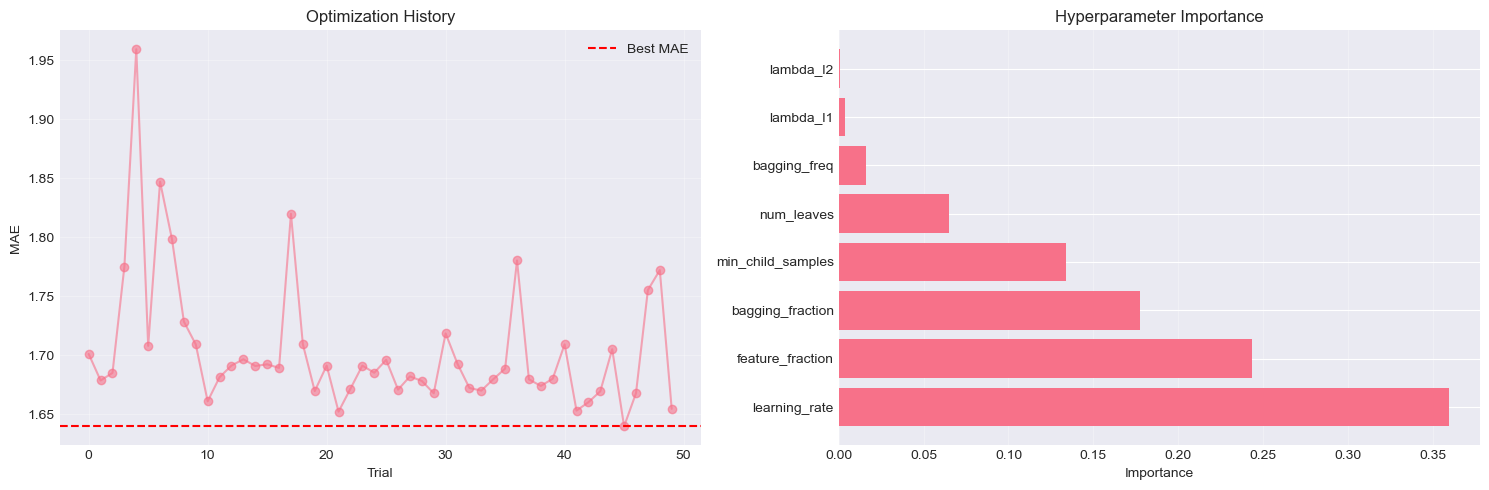

In [26]:
# Visualize optimization history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Optimization history
ax = axes[0]
trials_df = study.trials_dataframe()
ax.plot(trials_df['number'], trials_df['value'], marker='o', alpha=0.6)
ax.axhline(y=study.best_value, color='r', linestyle='--', label='Best MAE')
ax.set_xlabel('Trial')
ax.set_ylabel('MAE')
ax.set_title('Optimization History')
ax.legend()
ax.grid(True, alpha=0.3)

# Parameter importances
ax = axes[1]
importance = optuna.importance.get_param_importances(study)
params = list(importance.keys())
values = list(importance.values())
ax.barh(params, values)
ax.set_xlabel('Importance')
ax.set_title('Hyperparameter Importance')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 3. Train Final Model with Best Parameters

In [27]:
# Train final model with best parameters
best_params = study.best_params.copy()
best_params.update({
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
})

print("="*80)
print("TRAINING FINAL MODEL")
print("="*80)

# Combine train and validation for final training
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

train_data = lgb.Dataset(X_train_full, label=y_train_full)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train model
model = lgb.train(
    best_params,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

print(f"\n✓ Model trained with {model.best_iteration} iterations")

TRAINING FINAL MODEL
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[135]	valid_0's l1: 1.73142

✓ Model trained with 135 iterations
Early stopping, best iteration is:
[135]	valid_0's l1: 1.73142

✓ Model trained with 135 iterations


## 4. Model Evaluation

In [28]:
# Make predictions on all sets
y_train_pred = model.predict(X_train_full, num_iteration=model.best_iteration)
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Calculate metrics
train_mae = mean_absolute_error(y_train_full, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_full, y_train_pred))
train_r2 = r2_score(y_train_full, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("="*80)
print("MODEL PERFORMANCE")
print("="*80)
print(f"\nTraining Set:")
print(f"  MAE:  {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  R²:   {train_r2:.4f}")

print(f"\nTest Set:")
print(f"  MAE:  {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²:   {test_r2:.4f}")

# Check for overfitting
overfitting_ratio = test_mae / train_mae
print(f"\nOverfitting Check:")
print(f"  Test MAE / Train MAE: {overfitting_ratio:.2f}")
if overfitting_ratio < 1.2:
    print("  ✓ Model generalizes well")
elif overfitting_ratio < 1.5:
    print("  ⚠ Slight overfitting detected")
else:
    print("  ⚠ Significant overfitting detected")

MODEL PERFORMANCE

Training Set:
  MAE:  1.2563
  RMSE: 1.5860
  R²:   0.9863

Test Set:
  MAE:  1.7314
  RMSE: 2.1741
  R²:   0.9758

Overfitting Check:
  Test MAE / Train MAE: 1.38
  ⚠ Slight overfitting detected


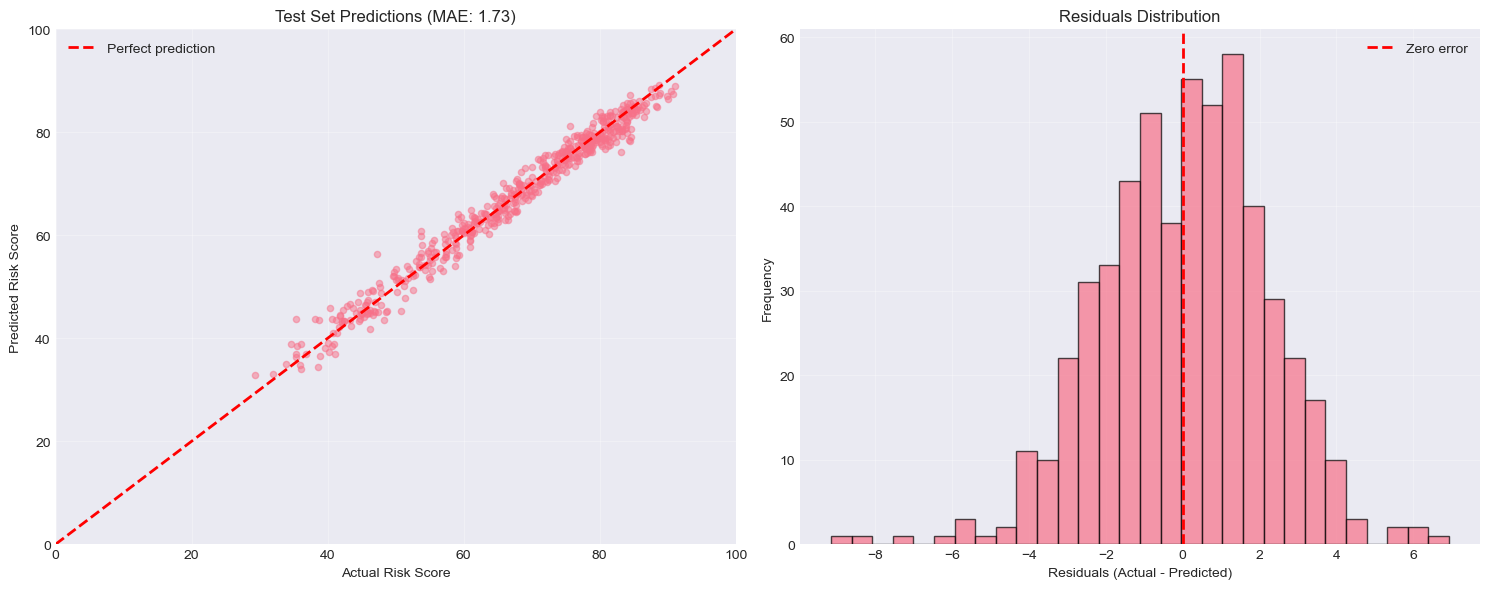


Residual Statistics:
  Mean: 0.0418
  Std:  2.1757


In [29]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Test set predictions
ax = axes[0]
ax.scatter(y_test, y_test_pred, alpha=0.5, s=20)
ax.plot([0, 100], [0, 100], 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual Risk Score')
ax.set_ylabel('Predicted Risk Score')
ax.set_title(f'Test Set Predictions (MAE: {test_mae:.2f})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# Residuals distribution
ax = axes[1]
residuals = y_test - y_test_pred
ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero error')
ax.set_xlabel('Residuals (Actual - Predicted)')
ax.set_ylabel('Frequency')
ax.set_title('Residuals Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.4f}")
print(f"  Std:  {residuals.std():.4f}")

TOP 15 MOST IMPORTANT FEATURES
                feature   importance
        region_suitable 2.319854e+06
             ndvi_score 4.591941e+05
            water_match 4.447472e+05
             temp_match 1.423050e+05
      crop_drought_sens 7.690565e+04
               ndvi_max 5.035926e+04
              ndvi_mean 2.318798e+04
          crop_category 1.922542e+04
                   crop 1.757872e+04
precipitation_annual_mm 1.629831e+04
               ndvi_std 1.609077e+04
              lst_max_c 1.566017e+04
          crop_temp_min 1.551506e+04
              longitude 1.480728e+04
        crop_frost_sens 1.280198e+04


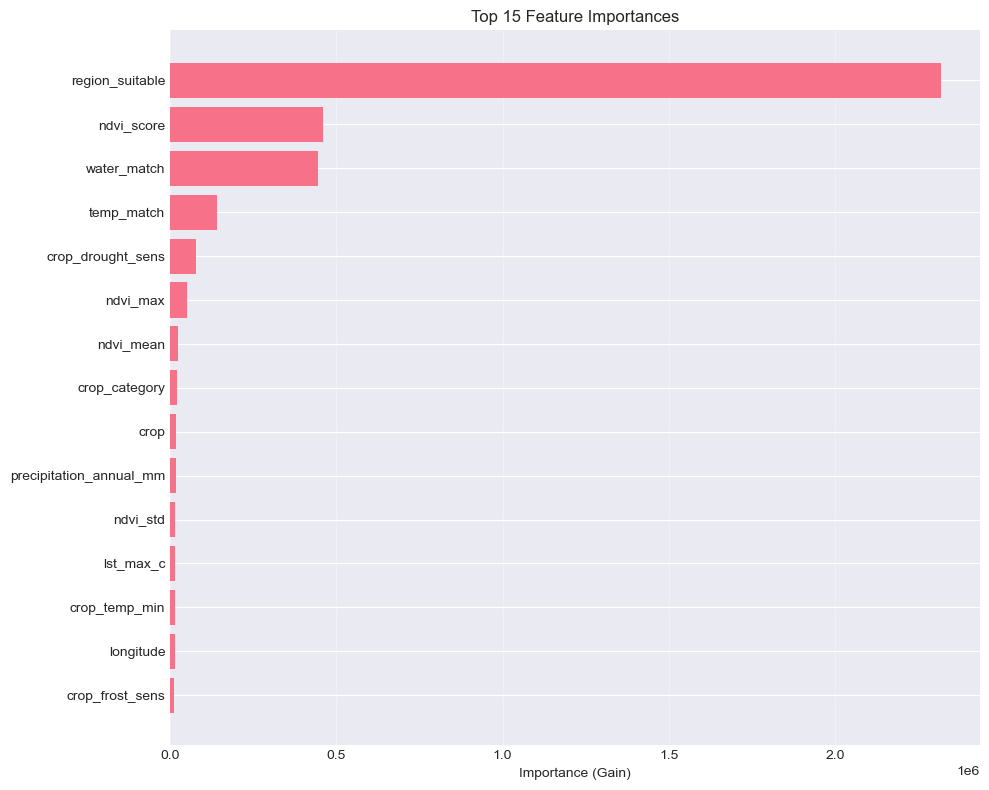

In [30]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("="*80)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*80)
print(importance_df.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Gain)')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 5. SHAP Explanations for Model Interpretability

In [31]:
# Create SHAP explainer
print("Calculating SHAP values (this may take a few minutes)...")

# Use a sample for faster computation
sample_size = min(500, len(X_test))
X_sample = X_test.sample(n=sample_size, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

print(f"✓ SHAP values calculated for {sample_size} samples")

Calculating SHAP values (this may take a few minutes)...
✓ SHAP values calculated for 500 samples
✓ SHAP values calculated for 500 samples


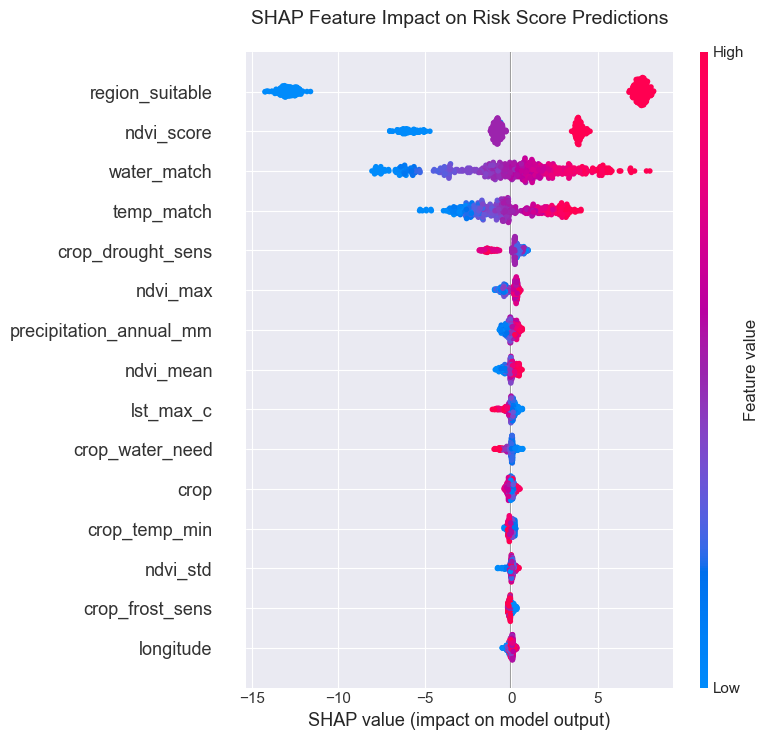

In [32]:
# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False, max_display=15)
plt.title('SHAP Feature Impact on Risk Score Predictions', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

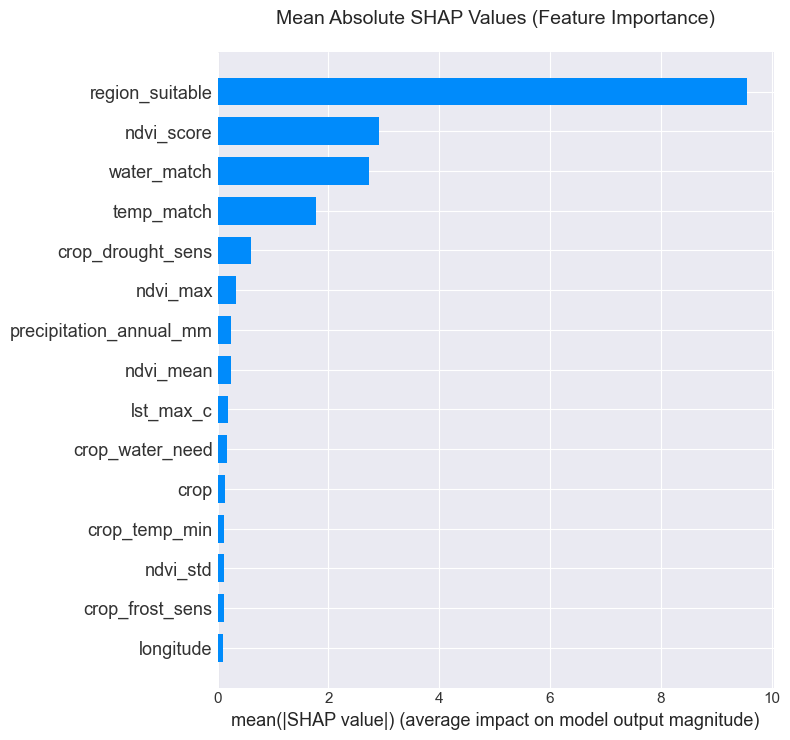

In [33]:
# SHAP Bar Plot - Feature importance by mean absolute SHAP value
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, plot_type="bar", show=False, max_display=15)
plt.title('Mean Absolute SHAP Values (Feature Importance)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [34]:
# Example predictions with explanations
print("="*80)
print("EXAMPLE PREDICTIONS WITH SHAP EXPLANATIONS")
print("="*80)

# Select diverse examples
example_indices = [0, len(X_sample)//3, 2*len(X_sample)//3]

for i, idx in enumerate(example_indices):
    # Get the actual index from X_sample
    sample_idx = X_sample.index[idx]
    
    actual = y_test.loc[sample_idx]
    predicted = model.predict(X_sample.iloc[idx:idx+1], num_iteration=model.best_iteration)[0]
    
    print(f"\nExample {i+1}:")
    print(f"  Actual Risk Score:    {actual:.2f}")
    print(f"  Predicted Risk Score: {predicted:.2f}")
    print(f"  Error:                {abs(actual - predicted):.2f}")
    
    # Top SHAP contributors
    shap_contrib = pd.DataFrame({
        'feature': feature_cols,
        'shap_value': shap_values[idx]
    }).sort_values('shap_value', key=abs, ascending=False)
    
    print(f"  Top 5 contributing features:")
    for _, row in shap_contrib.head(5).iterrows():
        direction = "↑" if row['shap_value'] > 0 else "↓"
        print(f"    {row['feature']:25s}: {row['shap_value']:+.2f} {direction}")

EXAMPLE PREDICTIONS WITH SHAP EXPLANATIONS

Example 1:
  Actual Risk Score:    81.60
  Predicted Risk Score: 81.39
  Error:                0.21
  Top 5 contributing features:
    region_suitable          : +7.86 ↑
    temp_match               : +3.38 ↑
    water_match              : +1.38 ↑
    ndvi_score               : -0.85 ↓
    precipitation_annual_mm  : +0.54 ↑

Example 2:
  Actual Risk Score:    72.40
  Predicted Risk Score: 71.87
  Error:                0.53
  Top 5 contributing features:
    region_suitable          : +7.51 ↑
    temp_match               : -3.01 ↓
    water_match              : +1.15 ↑
    ndvi_score               : -1.01 ↓
    ndvi_max                 : -0.60 ↓

Example 3:
  Actual Risk Score:    69.20
  Predicted Risk Score: 68.40
  Error:                0.80
  Top 5 contributing features:
    region_suitable          : +7.39 ↑
    ndvi_score               : -6.02 ↓
    temp_match               : -1.62 ↓
    water_match              : +1.37 ↑
    ndvi_max   

## 6. Save Model and Metadata

In [35]:
# Create models directory
models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

# Prepare model artifacts
model_artifacts = {
    'model': model,
    'label_encoders': label_encoders,
    'feature_cols': feature_cols,
    'categorical_cols': categorical_cols,
    'numerical_cols': numerical_cols,
    'best_params': best_params,
}

# Save model
model_path = models_dir / "agrorisk_model.joblib"
joblib.dump(model_artifacts, model_path)
print(f"✓ Model saved to: {model_path}")

# Save metadata
metadata = {
    'training_date': datetime.now().isoformat(),
    'model_type': 'LightGBM',
    'n_features': len(feature_cols),
    'n_samples_train': len(X_train_full),
    'n_samples_test': len(X_test),
    'best_iteration': int(model.best_iteration),
    'hyperparameters': best_params,
    'performance': {
        'train_mae': float(train_mae),
        'train_rmse': float(train_rmse),
        'train_r2': float(train_r2),
        'test_mae': float(test_mae),
        'test_rmse': float(test_rmse),
        'test_r2': float(test_r2),
    },
    'feature_importance': importance_df.to_dict('records'),
    'feature_columns': feature_cols,
    'categorical_columns': categorical_cols,
}

metadata_path = models_dir / "model_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved to: {metadata_path}")

# Save human-readable summary
summary_path = models_dir / "agrorisk_model.txt"
with open(summary_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("AGRORISK MODEL SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(f"Training Date: {metadata['training_date']}\n")
    f.write(f"Model Type: {metadata['model_type']}\n")
    f.write(f"Best Iteration: {metadata['best_iteration']}\n\n")
    
    f.write("Performance Metrics:\n")
    f.write(f"  Test MAE:  {test_mae:.4f}\n")
    f.write(f"  Test RMSE: {test_rmse:.4f}\n")
    f.write(f"  Test R²:   {test_r2:.4f}\n\n")
    
    f.write("Top 10 Important Features:\n")
    for i, row in importance_df.head(10).iterrows():
        f.write(f"  {i+1}. {row['feature']:30s} {row['importance']:.2f}\n")

print(f"✓ Summary saved to: {summary_path}")

print("\n" + "="*80)
print("MODEL TRAINING COMPLETE")
print("="*80)
print(f"✓ Model file: {model_path}")
print(f"✓ Metadata:   {metadata_path}")
print(f"✓ Summary:    {summary_path}")
print(f"\nModel ready for deployment!")

✓ Model saved to: ../models/agrorisk_model.joblib
✓ Metadata saved to: ../models/model_metadata.json
✓ Summary saved to: ../models/agrorisk_model.txt

MODEL TRAINING COMPLETE
✓ Model file: ../models/agrorisk_model.joblib
✓ Metadata:   ../models/model_metadata.json
✓ Summary:    ../models/agrorisk_model.txt

Model ready for deployment!
